<a href="https://colab.research.google.com/github/Balaji430/flight-status/blob/master/Flights_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas.util.testing as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install dmba
from dmba import classificationSummary, gainsChart, liftChart

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


no display found. Using non-interactive Agg backend


In [ ]:
delay = pd.read_csv('/content/drive/My Drive/DMBA/dmba/FlightDelays.csv')

In [ ]:
delay_df = delay.copy()

In [ ]:
delay.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [ ]:
delay['isDelayed'] = [1 if status == 'delayed' else 0 for status in delay['Flight Status']]

In [ ]:
def createGraph(group, xlabel, axis):
    groupAverage = delay.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK':
      groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
      groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

In [ ]:
def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delay['CRS_DEP_TIME'] // 100,
                            'isDelayed': delay['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')

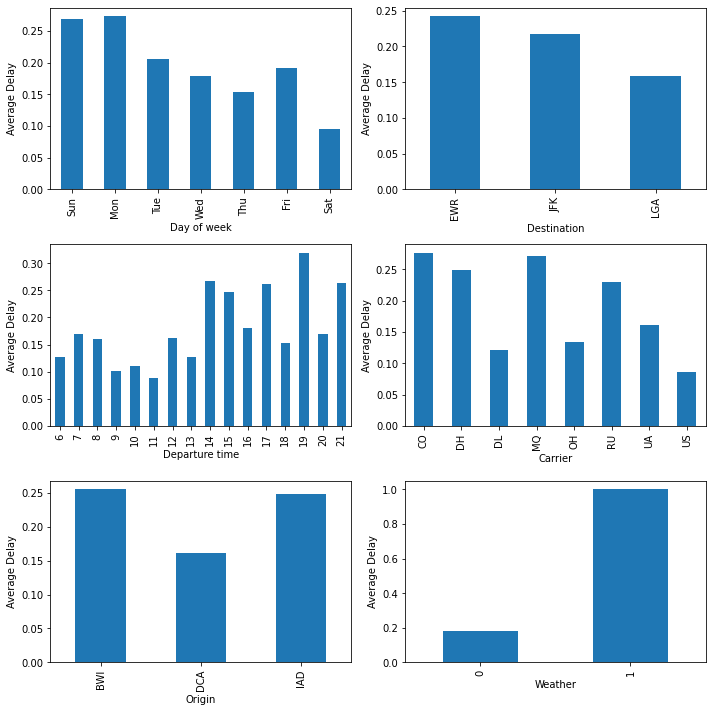

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
createGraph('DAY_WEEK', 'Day of week', axes[0][0])
createGraph('DEST', 'Destination', axes[0][1])
graphDepartureTime('Departure time', axes[1][0])
createGraph('CARRIER', 'Carrier', axes[1][1])
createGraph('ORIGIN', 'Origin', axes[2][0])
createGraph('Weather', 'Weather', axes[2][1])
plt.tight_layout()

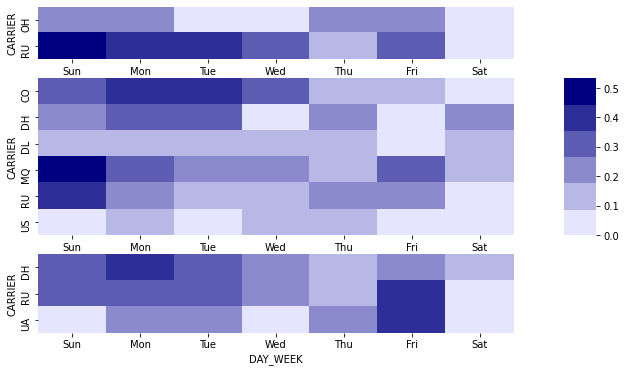

In [ ]:
agg = delay.groupby(['ORIGIN', 'DAY_WEEK','CARRIER']).isDelayed.mean()
agg = agg.reset_index()
# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delay.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
    gridspec_kw = {'height_ratios': height_ratios, 'width_ratios':[15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')
maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delay.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin],values='isDelayed', aggfunc=np.sum,index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0,vmax=maxIsDelay,cbar_ax=axes[1][1],cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat'])
if i != 2:
  ax.get_xaxis().set_visible(False)
  ax.set_ylabel('Airport ' + origin)
  plt.show()

In [ ]:
delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRS_DEP_TIME   2201 non-null   int64 
 1   CARRIER        2201 non-null   object
 2   DEP_TIME       2201 non-null   int64 
 3   DEST           2201 non-null   object
 4   DISTANCE       2201 non-null   int64 
 5   FL_DATE        2201 non-null   object
 6   FL_NUM         2201 non-null   int64 
 7   ORIGIN         2201 non-null   object
 8   Weather        2201 non-null   int64 
 9   DAY_WEEK       2201 non-null   int64 
 10  DAY_OF_MONTH   2201 non-null   int64 
 11  TAIL_NUM       2201 non-null   object
 12  Flight Status  2201 non-null   object
 13  isDelayed      2201 non-null   int64 
dtypes: int64(8), object(6)
memory usage: 240.9+ KB


In [ ]:
delay['DAY_WEEK'].unique()

array([4, 5, 6, 7, 1, 2, 3])

In [ ]:
delay['DAY_WEEK'] = delay['DAY_WEEK'].astype('category')

In [ ]:
# create hourly bins departure time
delay.CRS_DEP_TIME = [round(t / 100) for t in delay.CRS_DEP_TIME]
delay.CRS_DEP_TIME = delay.CRS_DEP_TIME.astype('category')

In [ ]:
delay.CRS_DEP_TIME.unique()

[15, 16, 12, 17, 10, ..., 18, 13, 19, 11, 7]
Length: 16
Categories (16, int64): [15, 16, 12, 17, ..., 13, 19, 11, 7]

In [ ]:
predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST','CARRIER', 'Weather']
outcome = 'isDelayed'

In [ ]:
X = pd.get_dummies(delay[predictors], drop_first=True)
y = delay[outcome]

In [ ]:
X.head()

,Weather,DAY_WEEK_2,DAY_WEEK_3,DAY_WEEK_4,DAY_WEEK_5,DAY_WEEK_6,DAY_WEEK_7,CRS_DEP_TIME_7,CRS_DEP_TIME_8,CRS_DEP_TIME_9,CRS_DEP_TIME_10,CRS_DEP_TIME_11,CRS_DEP_TIME_12,CRS_DEP_TIME_13,CRS_DEP_TIME_14,CRS_DEP_TIME_15,CRS_DEP_TIME_16,CRS_DEP_TIME_17,CRS_DEP_TIME_18,CRS_DEP_TIME_19,CRS_DEP_TIME_20,CRS_DEP_TIME_21,ORIGIN_DCA,ORIGIN_IAD,DEST_JFK,DEST_LGA,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0


In [ ]:
classes = ['ontime','delayed']

In [ ]:
!pip install mord
!pip install dmba

In [ ]:
from dmba import AIC_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)
print('intercept ', logit_full.intercept_[0])
df_coef = pd.DataFrame({'coeff': logit_full.coef_[0]},index=X.columns)
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X),df = len(train_X.columns) + 1))

intercept  -1.2191099739696425
AIC 1004.5346225948085


In [ ]:
AIC_score(valid_y, logit_full.predict(valid_X),df = len(train_X.columns) + 1)

1004.5346225948085

In [ ]:
df_coef

,coeff
Weather,9.325046
DAY_WEEK_2,-0.597927
DAY_WEEK_3,-0.704795
DAY_WEEK_4,-0.798677
DAY_WEEK_5,-0.295774
DAY_WEEK_6,-1.129240
DAY_WEEK_7,-0.135377
CRS_DEP_TIME_7,0.631495
CRS_DEP_TIME_8,0.382266
CRS_DEP_TIME_9,-0.365022


Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


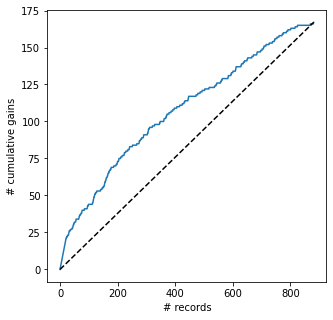

In [ ]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted':logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'],ascending=False)
# confusion matrix
classificationSummary(full_result.actual, full_result.predicted,class_names=classes)
gainsChart(full_result.actual, figsize=[5, 5])
plt.show()

In [ ]:
full_result

,actual,p(0),p(1),predicted
1827,1,0.000069,0.999931,1
1864,1,0.000104,0.999896,1
1910,1,0.000148,0.999852,1
1744,1,0.000160,0.999840,1
1849,1,0.000162,0.999838,1
...,...,...,...,...
351,0,0.976077,0.023923,0
669,0,0.978045,0.021955,0
140,0,0.978045,0.021955,0
434,0,0.978450,0.021550,0


In [ ]:
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delay.DAY_WEEK],
    'Weather' : delay.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH","RU") else 0 for d in delay.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delay.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delay.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delay.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delay.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delay['Flight Status']],
})

In [ ]:
delays_red_df

,Sun_Mon,Weather,CARRIER_CO_MQ_DH_RU,MORNING,NOON,AFTER2P,EVENING,isDelayed
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0
2,0,0,1,0,1,0,0,0
3,0,0,1,0,0,1,0,0
4,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2196,0,0,1,1,0,0,0,0
2197,0,0,1,0,0,1,0,0
2198,0,0,1,0,0,1,0,0
2199,0,0,1,0,0,1,0,0


In [ ]:
X_red = delays_red_df.drop(columns=['isDelayed'])
y_red = delays_red_df['isDelayed']
train_X_red, valid_X_red, train_y_red, valid_y_red = train_test_split(X_red, y_red, test_size=0.4,random_state=1)
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
logit_red = LogisticRegressionCV(penalty="l1",solver='liblinear', cv=5)
logit_red.fit(train_X_red, train_y_red)
print('intercept ', logit_red.intercept_[0])
df_red = pd.DataFrame({'coeff': logit_red.coef_[0]},index=X_red.columns)
print('AIC', AIC_score(valid_y_red, logit_red.predict(valid_X_red),df=len(train_X_red.columns) + 1))
# confusion matrix
classificationSummary(valid_y_red, logit_red.predict(valid_X_red),class_names=classes)

intercept  -2.2873550327189394
AIC 934.6153607819033
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


In [ ]:
df_red

,coeff
Sun_Mon,0.577943
Weather,4.977939
CARRIER_CO_MQ_DH_RU,1.298833
MORNING,-0.583277
NOON,-0.665906
AFTER2P,-0.055211
EVENING,0.560828


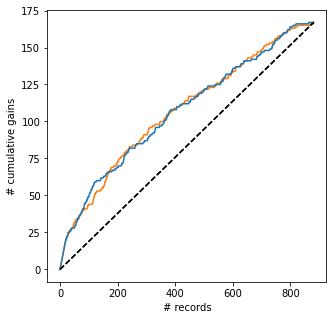

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X_red)
red_result = pd.DataFrame({'actual': valid_y_red,
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X_red),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)
ax = gainsChart(full_result.actual, color='C1', figsize=[5, 5])
gainsChart(red_result.actual, color='C0', ax=ax)